## Introduction

This notebook runs some basic queries using the PDS API - for full documents, see https://nasa-pds.github.io/pds-api/

The API is built on an OpenAPI spec and Swagger can be used for testing and stub code generation:

https://pds.nasa.gov/api/search/1/swagger-ui/

This works only for PDS4 products and is built from the ground-up on the PDS Information Model, which is most commonly expressed in XML. Usually we work with XML using xpath, which is very powerful, but doesn't really work with OpenSearch which is hosting the underlying registry. So a "flattened" xpath-like representation is used, where PDS4 attributes (XML elements) are notated simply by their parent node and the leaf node.

So, 

`Product_Observational/Observation_Area/Time_Coordinates/start_date_time`

becomes

`pds:Time_Coordinates.pds:start_date_time`

where a period is used in place of a slash. In 99% of cases this loss of hierarchy is not important, but there is some level of ambiguity, and future API versions will have a way to deal with this.


## Imports and setup

In [1]:
import pandas as pd
import requests
import json
from pds4_tools import read
import matplotlib.pyplot as plt
import matplotlib.dates as md

Two URLs are used here - the `pds_url` is the global PDS API base url, whilst `psa_url` will search only those products submitted by PSA

In [2]:
pds_url = 'https://pds.nasa.gov/api/search/1/'
# psa_url = 'https://pds.nasa.gov/api/search-psa/1/'

## Basic classes

The basic API query format is:
```
{root}/api/search/1/classes/{product_class}[?[{query-parameter}={query-parameter-value}]*]
```
where the classes can be retrieved here:

In [3]:
requests.get('https://pds.nasa.gov/api/search/1/classes').content.decode()

'["aip","ancillary","attribute-definition","browse","bundle","class-definition","collection","context","dip","dip-deep-archive","data-set-pds3","document","external","file-repository","file-text","instrument-host-pds3","instrument-pds3","metadata-supplemental","mission-pds3","native","observational","proxy-pds3","sip","sip-deep-archive","spice-kernel","service","software","subscription-pds3","target-pds3","thumbnail","update","volume-pds3","volume-set-pds3","xml-schema","zipped"]'

So we can search for different levels of the PDS hierarchy - bundles, collections and products - and we can drill up and down this hierarchy.

There is a defined query syntax which can be used in the "q" parameters to restrict the results:

## Find raw data collections

In [4]:
r = requests.get(pds_url + 'classes/collection',
    params={
        'limit': 10,
        'q': '(pds:Primary_Result_Summary.pds:processing_level eq "Raw")'})

How many hits does this query return?

In [5]:
r.json()['summary']['hits']

1423

This is the total number of matching results, although by passing the query parameter `limit=10` above we only return those:

In [6]:
for collection in r.json()['data']:
    print(collection['id'])

urn:nasa:pds:a12sws_raw_arcsav:document::1.0
urn:nasa:pds:a15hfe_calibrated_arcsav:document::1.0
urn:nasa:pds:a17lsg_raw_arcsav:data::1.0
urn:nasa:pds:annex_ehlmann_caltech_msl_msam2:document::1.0
urn:nasa:pds:cassini-caps-raw:data-sng::1.0
urn:nasa:pds:cassini-mimi-inca-raw:data-accumulation-rates::1.0
urn:nasa:pds:cassini-mimi-lemms-raw:data-fine-accumulation-rates::1.0
urn:nasa:pds:cassini-mimi-lemms-raw:data-pha::1.0
urn:nasa:pds:cassini_iss_cruise:data_raw::1.0
urn:nasa:pds:cassini_iss_saturn:data_raw::1.0


If you want to find just PSA data you can add `q=(ops:Harvest_Info.ops:node_name eq "PSA")` to your query

In [7]:
r = requests.get(pds_url + 'classes/collection',
    params={
        'limit': 10,
        'q': '((pds:Primary_Result_Summary.pds:processing_level eq "Raw") and (ops:Harvest_Info.ops:node_name eq "PSA"))'})

In [8]:
for collection in r.json()['data']:
    print(collection['id'])

urn:esa:psa:bc_mtm_mcam:document::4.0
urn:esa:psa:em16_tgo_acs:data_raw::104.2
urn:esa:psa:bc_mtm_mcam:data_raw::13.1
urn:esa:psa:em16_tgo_frd:data_raw::75.2
urn:esa:psa:em16_tgo_cas:data_raw::105.1
urn:esa:psa:em16_tgo_nmd:data_calibrated::9.1
urn:esa:psa:bc_mtm_mcam:browse::13.1
urn:esa:psa:em16_tgo_nmd:data_raw::109.1


## Find bundles per mission

In [9]:
r = requests.get(pds_url + 'classes/collection',
    params={
        'limit': 100,
        'q': 'ref_lid_investigation eq "urn:esa:psa:context:investigation:mission.bc"'})

In [10]:
print(r.json()['summary']['hits'])
for collection in r.json()['data']:
    print(collection['id'])

17
urn:esa:psa:bc_spice:document::1.0
urn:esa:psa:bc_spice:document::3.0
urn:esa:psa:bc_spice:document::2.0
urn:esa:psa:bc_spice:spice_kernels::4.0
urn:esa:psa:bc_spice:miscellaneous::5.0
urn:esa:psa:bc_spice:spice_kernels::2.0
urn:esa:psa:bc_spice:miscellaneous::2.0
urn:esa:psa:bc_spice:miscellaneous::4.0
urn:esa:psa:bc_spice:spice_kernels::5.0
urn:esa:psa:bc_mtm_mcam:document::4.0
urn:esa:psa:bc_mtm_mcam:data_raw::13.1
urn:esa:psa:bc_spice:miscellaneous::4.0
urn:esa:psa:bc_mtm_mcam:browse::13.1
urn:esa:psa:bc_spice:spice_kernels::4.0
urn:esa:psa:bc_spice:miscellaneous::4.0
urn:esa:psa:bc_spice:spice_kernels::4.0
urn:esa:psa:bc_spice:document::2.0


## Find collections by instrument

We can also search for data collections knowing the instrument - in the future there will probably be simplified ways (e.g. wrappers) to make it easy, but now you have to know the ID of the instrument in PDS4-speak

In [11]:
r = requests.get(pds_url + 'classes/collection',
    params={
        'limit': 100,
        'q': 'ref_lid_instrument eq "urn:esa:psa:context:instrument:tgo.acs"'})

In [12]:
print(r.json()['summary']['hits'])

3


In [13]:
print(r.json()['summary']['hits'])
for collection in r.json()['data']:
    print(collection['id'])

3
urn:esa:psa:em16_tgo_acs:data_raw::104.2
urn:esa:psa:em16_tgo_acs:data_calibrated::11.2
urn:esa:psa:em16_tgo_acs:data_partially_processed::52.2


From here we could dive further into the contents of these collections.

## Resolve a LID

It's also possible to take a LID (identifier) and resolve this in the registry to find the corresponding meta-data, and indeed to track down the data. Once ALL data from ALL PDS nodes and IPDA partners are here, this will be a great way to find who hosts certain data.

Here I use an MCAM lid and simply look it up against the PDS main product endpoint:

In [14]:
lid = 'urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_cam3_image_20190412t180845_62_f__t0020'

In [15]:
r = requests.get('https://pds.nasa.gov/api/search/1/products/{:s}'.format(lid))

If this is found, we get back a simplified label converted to json - if we look at the just the top level elements of this json:

In [16]:
r.json()

{'id': 'urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_cam3_image_20190412t180845_62_f__t0020::1.0',
 'type': 'Product_Observational',
 'title': 'BepiColombo MCAM image product',
 'start_date_time': '2019-04-12T18:08:45.970Z',
 'stop_date_time': '2019-04-12T18:08:45.990Z',
 'investigations': [{'id': 'urn:esa:psa:context:investigation:mission.bc',
   'href': 'https://pds.mcp.nasa.gov/api/search/1/products/urn:esa:psa:context:investigation:mission.bc'}],
 'observing_system_components': [{'id': 'urn:esa:psa:context:instrument_host:spacecraft.mtm',
   'href': 'https://pds.mcp.nasa.gov/api/search/1/products/urn:esa:psa:context:instrument_host:spacecraft.mtm'},
  {'id': 'urn:esa:psa:context:instrument:mcam.mtm',
   'href': 'https://pds.mcp.nasa.gov/api/search/1/products/urn:esa:psa:context:instrument:mcam.mtm'}],
 'targets': [{'id': 'urn:nasa:pds:context:target:calibrator.spacecraft_deck',
   'href': 'https://pds.mcp.nasa.gov/api/search/1/products/urn:nasa:pds:context:target:calibrator.spacecra

And we can look at one in more detail, e.g. target:

In [17]:
print(json.dumps(r.json()['targets'], indent=2))

[
  {
    "id": "urn:nasa:pds:context:target:calibrator.spacecraft_deck",
    "href": "https://pds.mcp.nasa.gov/api/search/1/products/urn:nasa:pds:context:target:calibrator.spacecraft_deck"
  }
]


So this is the LID of the target context product, and also a URL to read this if needed.

## Filter on dates

The API uses a query syntax for parameter "q" which allows for any attribute in the PDS4 world to be searched, using a flattened version of the XML label. This means that you can search on the last part of the xpath, using a "dot" instead of a slash to separate parent and child elements, e.g.

In [18]:
r = requests.get(pds_url + 'products',
    params={
        'limit': 0,
        'q': 'pds:Time_Coordinates.pds:start_date_time gt "2023-01-01T00:00:00Z"'})

In [19]:
r.json()['summary']['hits']

2601406

Let's narrow it down more - note that "extreme bracketing" is needed for more complex queries:

In [20]:
r = requests.get(pds_url + 'products',
    params={
        'q': """
            ((pds:Time_Coordinates.pds:start_date_time gt "2021-01-01T00:00:00Z") and 
             (pds:Time_Coordinates.pds:start_date_time lt "2021-01-04T00:00:00Z") and 
             ('ref_lid_investigation eq "urn:esa:psa:context:investigation:mission.bc"))
             """})

In [21]:
r.json()['summary']['hits']

56

In [22]:
for collection in r.json()['data']:
    print(collection['id'])

urn:esa:psa:bc_spice:spice_kernels:ck_bc_mpo_sa_scm_20210101_20220101_s20220106_v01.bc::1.0
urn:esa:psa:bc_mpo_mag:data_derived:mag_der_sc_ib_a001_scf_00000_20210102::1.0
urn:esa:psa:bc:miscellaneous:mpo_raw_hk_aocs_measured_attitude_20210102::0.1
urn:esa:psa:bc:miscellaneous:mpo_raw_hk_hga_position_20210101::0.1
urn:esa:psa:bc:miscellaneous:mtm_raw_hk_sa_position_20210103::0.1
urn:esa:psa:bc_spice:spice_kernels:ck_bc_mpo_sc_scm_20210101_20220101_s20220106_v01.bc::1.0
urn:esa:psa:bc_mpo_mag:data_derived:mag_der_sc_ob_a001_e2k_00000_20210103::1.0
urn:esa:psa:bc_mpo_mag:data_derived:mag_der_sc_ob_a001_scf_00000_20210103::1.0
urn:esa:psa:bc:miscellaneous:mpo_raw_hk_hga_position_20210103::0.1
urn:esa:psa:bc:miscellaneous:mpo_raw_hk_sa_position_20210101::0.1
urn:esa:psa:bc:miscellaneous:mpo_raw_hk_sa_position_20210102::0.1
urn:esa:psa:bc:miscellaneous:mtm_raw_hk_sa_position_20210102::0.1
urn:esa:psa:bc_spice:spice_kernels:ck_bc_mtm_sa_scm_20210101_20220101_s20220106_v01.bc::1.0
urn:esa:psa:

We can grab some basic data from this response and use it to load the data if we want

In [23]:
data = pd.DataFrame.from_dict(r.json()['data'])
data['label_url'] = data.metadata.apply( lambda meta: meta['label_url'] )

In [24]:
data.head()

,id,type,title,start_date_time,stop_date_time,investigations,observing_system_components,targets,metadata,properties,label_url
0,urn:esa:psa:bc_spice:spice_kernels:ck_bc_mpo_s...,Product_SPICE_Kernel,bc_mpo_sa_scm_20210101_20220101_s20220106_v01.bc,2021-01-01T00:00:13.666Z,2022-01-01T23:59:26.906Z,[{'id': 'urn:esa:psa:context:investigation:mis...,[{'id': 'urn:esa:psa:context:instrument_host:s...,[{'id': 'urn:nasa:pds:context:target:planet.me...,{'creation_date_time': '2023-02-01T14:11:50.92...,{'lid': ['urn:esa:psa:bc_spice:spice_kernels:c...,https://archives.esac.esa.int/psa/repo/esa/psa...
1,urn:esa:psa:bc_mpo_mag:data_derived:mag_der_sc...,Product_Observational,BepiColombo MPO MPO-MAG CRUISE DERIVED AVERAGE...,2021-01-02T00:00:09Z,2021-01-02T23:59:59Z,[{'id': 'urn:esa:psa:context:investigation:mis...,[{'id': 'urn:esa:psa:context:instrument_host:s...,[{'id': 'urn:nasa:pds:context:target:plasma_st...,"{'creation_date_time': '2022-12-07T11:39:16Z',...",{'pds:Modification_Detail.pds:description': ['...,https://archives.esac.esa.int/psa/repo/esa/psa...
2,urn:esa:psa:bc:miscellaneous:mpo_raw_hk_aocs_m...,Product_Observational,BepiColombo Spacecraft Measured Attitude,2021-01-02T00:00:09.039Z,2021-01-02T23:59:59.038Z,[{'id': 'urn:esa:psa:context:investigation:mis...,[{'id': 'urn:esa:psa:context:instrument_host:s...,[{'id': 'urn:nasa:pds:context:target:calibrato...,"{'creation_date_time': '2023-03-13T09:24:38Z',...",{'pds:Modification_Detail.pds:description': ['...,https://archives.esac.esa.int/psa/repo/esa/psa...
3,urn:esa:psa:bc:miscellaneous:mpo_raw_hk_hga_po...,Product_Observational,BepiColombo Spacecraft MPO High Gain Antenna (...,2021-01-01T00:00:13.665Z,2021-01-01T23:59:53.664Z,[{'id': 'urn:esa:psa:context:investigation:mis...,[{'id': 'urn:esa:psa:context:instrument_host:s...,[{'id': 'urn:nasa:pds:context:target:calibrato...,"{'creation_date_time': '2023-03-07T14:30:45Z',...",{'pds:Modification_Detail.pds:description': ['...,https://archives.esac.esa.int/psa/repo/esa/psa...
4,urn:esa:psa:bc:miscellaneous:mtm_raw_hk_sa_pos...,Product_Observational,BepiColombo Spacecraft MTM Solar Array (SA) Po...,2021-01-03T00:00:13.663Z,2021-01-03T23:59:53.663Z,[{'id': 'urn:esa:psa:context:investigation:mis...,[{'id': 'urn:esa:psa:context:instrument_host:s...,[{'id': 'urn:nasa:pds:context:target:calibrato...,"{'creation_date_time': '2023-03-07T14:33:30Z',...",{'pds:Modification_Detail.pds:description': ['...,https://archives.esac.esa.int/psa/repo/esa/psa...


Let's just pick some specific data that we know are there...

In [25]:
gyro = data[data.id.str.contains('aocs_imu_angular_rate', case=False)][['id','label_url']]
gyro

,id,label_url
19,urn:esa:psa:bc:miscellaneous:mpo_raw_hk_aocs_i...,https://archives.esac.esa.int/psa/repo/esa/psa...
25,urn:esa:psa:bc:miscellaneous:mpo_raw_hk_aocs_i...,https://archives.esac.esa.int/psa/repo/esa/psa...
43,urn:esa:psa:bc:miscellaneous:mpo_raw_hk_aocs_i...,https://archives.esac.esa.int/psa/repo/esa/psa...


And we can simply read these products, now we know their URL, into memory and plot them. First we grab these and put them in a pandas DataFrame:

In [26]:
data_list = []
for index, url in gyro.label_url.items():
    data_list.append(pd.DataFrame(read(gyro.label_url.iloc[0])[0].data))
gyro_data = pd.concat(data_list)
gyro_data.head()

Processing label: https://archives.esac.esa.int/psa/repo/esa/psa/bc/miscellaneous/2023-04-18/mpo_raw_hk_aocs_imu_angular_rate_20210103/0.1/mpo_raw_hk_aocs_imu_angular_rate_20210103.xml
Now processing a Table_Character structure: Spacecraft AOCS IMU Measured Angular Rate Table
100% [==================================================] (1.37 / 1.37 MB)
Processing label: https://archives.esac.esa.int/psa/repo/esa/psa/bc/miscellaneous/2023-04-18/mpo_raw_hk_aocs_imu_angular_rate_20210103/0.1/mpo_raw_hk_aocs_imu_angular_rate_20210103.xml
Now processing a Table_Character structure: Spacecraft AOCS IMU Measured Angular Rate Table
Processing label: https://archives.esac.esa.int/psa/repo/esa/psa/bc/miscellaneous/2023-04-18/mpo_raw_hk_aocs_imu_angular_rate_20210103/0.1/mpo_raw_hk_aocs_imu_angular_rate_20210103.xml
Now processing a Table_Character structure: Spacecraft AOCS IMU Measured Angular Rate Table


,TIME_UTC,TIME_OBT,IMU_MEASURED_ANGULAR_RATE_X,IMU_MEASURED_ANGULAR_RATE_Y,IMU_MEASURED_ANGULAR_RATE_Z
0,2021-01-03T00:00:24.515Z,1/0674352023:16612,-6.982302e-07,-7.546772e-07,-2.242171e-06
1,2021-01-03T00:01:24.515Z,1/0674352083:16617,1.109448e-07,5.544054e-08,1.801969e-07
2,2021-01-03T00:02:24.514Z,1/0674352143:16590,1.109448e-07,5.544054e-08,1.801969e-07
3,2021-01-03T00:03:24.515Z,1/0674352203:16618,1.082670e-07,5.421574e-08,-1.434368e-06
4,2021-01-03T00:04:24.514Z,1/0674352263:16591,1.109448e-07,5.544054e-08,1.801969e-07


Now we tidy up a bit and make sure that time data are recognised as such:

In [27]:
gyro_data.TIME_UTC = pd.to_datetime(gyro_data.TIME_UTC)
gyro_data.set_index('TIME_UTC', drop=True, inplace=True)

And we can plot away

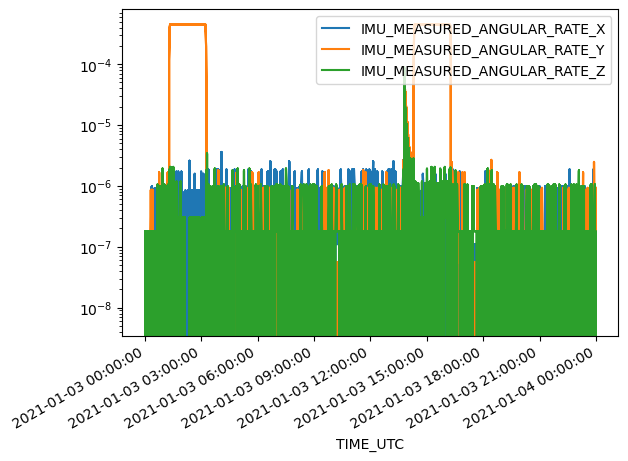

In [28]:
ax = gyro_data.plot(y=['IMU_MEASURED_ANGULAR_RATE_X','IMU_MEASURED_ANGULAR_RATE_Y','IMU_MEASURED_ANGULAR_RATE_Z'], logy=True)
ax.get_figure().autofmt_xdate()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

## Specifying returned fields

Instead of returning entire labels, or simplified meta-data, we can also request specific fields. Note that here we also test returning a CSV rather than json:

In [29]:
r = requests.get(pds_url + 'products',
    params={
        'limit': 10,
         'q': 'pds:Time_Coordinates.pds:start_date_time gt "2023-01-01T00:00:00Z"',
         'fields': 'lid, pds:Time_Coordinates/pds:start_date_time, pds:Time_Coordinates/pds:stop_date_time'},
     headers={'Accept': 'text/csv'})

In [30]:
print(r.content.decode())

lid,pds:Time_Coordinates.pds:start_date_time,pds:Time_Coordinates.pds:stop_date_time
"urn:nasa:pds:mars2020_moxie:data_calibrated:ox__0771_0735365292rdr0220390650moxi00117p01","2023-04-21T16:18:41Z","2023-04-21T20:00:34Z"
"urn:nasa:pds:mars2020_moxie:data_raw:ox__0771_0735365292edr0220390650moxi00117p02","2023-04-21T16:18:41Z","2023-04-21T20:00:34Z"
"urn:nasa:pds:clps.spice:miscellaneous","2024-01-08T08:09:02Z","2024-01-18T21:03:51Z"
"urn:nasa:pds:clps_to_2ab_nirvss_aim:ancillary","2024-01-11T14:10:11.879Z","2024-01-15T18:11:23.511Z"
"urn:nasa:pds:clps_to_2ab_nirvss_aim:browse","2024-01-11T14:10:11.879Z","2024-01-15T18:11:23.511Z"
"urn:nasa:pds:clps_to_2ab_nirvss_spc:ancillary","2024-01-11T14:10:11.879Z","2024-01-15T18:11:23.511Z"
"urn:nasa:pds:clps_to_2ab_nss:data_engineering_cal","2024-01-08T14:02:31.595Z","2024-01-14T22:53:27.492Z"
"urn:nasa:pds:maven.lpw.calibrated:data.w.e12burstmf","2024-03-01T00:00:00Z","2024-04-30T23:59:59.999Z"
"urn:nasa:pds:mars2020_rimfax:data_calibrated:rim

## Testing different return types

- application/json
    - Simplified JSON view of the PDS4 metadata label. Contains “flattened” PDS4 properties extracted from the metadata label
- application/xml
    - Same as application/json, but in an XML
- application/vnd.nasa.pds.pds4+json
    - JSON response containing the full PDS4 metadata translated to JSON, along with some additional supplemental
- application/vnd.nasa.pds.pds4+xml
    - Same as application/vnd.nasa.pds.pds4+json, but in an XML format. This response format contains the original PDS4 labels.
- application/kvp+json
    - JSON response containing key-value-pairs for the applicable metadata.
- text/csv
    - Returns a CSV table containing values for the parameters in the request. If no parameters were specified in the request, a default set is returned. The first row of the CSV is a header that describes the values in each column.
- text/html
    - JSON response embedded in an HTML body. This format is provided for requests coming from the browers (e.g. Google Chrome) URL bar.


CSV is another useful one, which we saw earlier.

## Filter by heliocentric distance

How test the ability to filter data by arbitrary meta-data - here let's use the spacecraft heliocentric distance from the geometry dictionary (included in the MCAM labels):

In [31]:
r = requests.get(pds_url + 'products',
    params={
        'limit': 10,
        'fields': 'geom:Distances_Specific.geom:spacecraft_heliocentric_distance',
        'q': 'geom:Distances_Specific.geom:spacecraft_heliocentric_distance gt 160000000'})

To make the data easier to work with, I'm taking the bits of interest and putting into a pandas dataframe:

In [32]:
data = pd.DataFrame.from_dict(r.json()['data'])
data['dist_sun'] = data.properties.apply( lambda prop: prop['geom:Distances_Specific.geom:spacecraft_heliocentric_distance'][0])
data['label_url'] = data.metadata.apply( lambda meta: meta['label_url'] )
d = data[['id','start_date_time','stop_date_time','dist_sun', 'label_url']]
d.head()

,id,start_date_time,stop_date_time,dist_sun,label_url
0,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,2019-06-03T04:27:59.920Z,2019-06-03T04:27:59.930Z,174635578.1218857,https://archives.esac.esa.int/psa/repo/esa/psa...
1,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,2019-09-02T06:16:28.930Z,2019-09-02T06:16:28.940Z,173870608.76979458,https://archives.esac.esa.int/psa/repo/esa/psa...
2,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,2019-09-20T05:40:04.910Z,2019-09-20T05:40:04.950Z,169507833.49136508,https://archives.esac.esa.int/psa/repo/esa/psa...
3,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,2019-09-13T05:46:40.920Z,2019-09-13T05:46:40.940Z,171350167.8587961,https://archives.esac.esa.int/psa/repo/esa/psa...
4,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,2019-08-13T07:33:40.950Z,2019-08-13T07:33:40.960Z,177192819.5987698,https://archives.esac.esa.int/psa/repo/esa/psa...


So now we have enough to work with these data, e.g. open by URL (label_url):

In [33]:
struct = read(d.iloc[0].label_url, quiet=True)

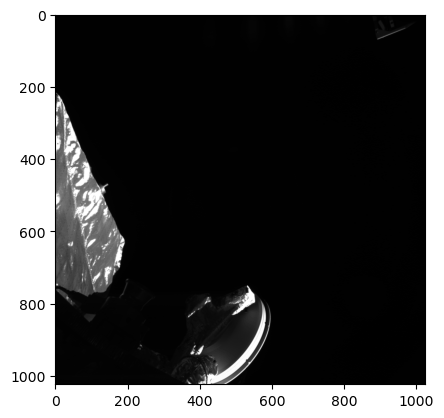

In [34]:
plt.imshow(struct['MCAM_image'].data, cmap=plt.cm.gray)

## Use cases

### Advanced search

This would be very powerful to include in the PSA UI, but there are a few things to address:

- should we take a local mirror of the OpenSearch data
    - so that we don't rely on PDS/AWS, and so PDS don't get a big bill from our UI usage


### Discovering specific data

A common use case for PDS4 archive scientists is wanting to find specific examples of how meta-data are used - in particular meta-data from discipline dictionaries. In the case below I wanted to find some test products encoding footprints in their labels:

In [35]:
r = requests.get(pds_url + 'products',
    params={
        'limit': 100,
        'q': '(geom:Pixel_Intercept.geom:pixel_latitude gt 0.0)',
        'fields': 'lid, geom:Pixel_Intercept.geom:pixel_latitude'},
     headers={'Accept': 'text/csv'})

In [36]:
print(r.content.decode())

geom:Pixel_Intercept.geom:pixel_latitude,lid
"3.09|3.25|2.93|2.93|3.25","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3674j163.img"
"2.43|2.59|2.27|2.27|2.59","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3646j163.img"
"1.93|2.09|1.77|1.77|2.09","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3637j163.img"
"1.76|1.92|1.60|1.60|1.92","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3630j163.img"
"6.05|6.22|5.88|5.88|6.22","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3792j163.img"
"11.17|11.34|10.99|10.99|11.34","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3984k163.img"
"10.22|10.40|10.05|10.05|10.40","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt3950k163.img"
"16.50|16.69|16.31|16.32|16.69","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt4167k163.img"
"20.09|20.28|19.89|19.89|20.28","urn:nasa:pds:clementine_lwir_bt:data_brightness_temperature:bt4291l163.img"